# 📡 Имитационное моделирование RFID системы в зависимости от параметра `Q` и количества меток в зоне чтения

В данном блокноте проводится имитацинное моделирование RFID системы для изучения зависимости вероятности чтения банка памяти `USER` от параметра, количества меток в зоне чтения, количества коллизий. Также изучается работа команды QueryAdjust и алгоритма коррекции `Q`

### Импорт необходимых модулей

In [1]:
import numpy as np

from pysim.experiments.utility.rfid_helper import(
    calculate_probs, generation_interval, plot_simulations_results
)
from pysim.models.rfid.params import default_params, inner_params, KMPH_TO_MPS_MUL
from pysim.experiments.utility.channel_helper import(
    find_zones, get_tag_rx
)

In [2]:
IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "../results/result_jsons/rfid/multiple_tag/"

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q`. Случай без коллизий и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

Как хорошо видно из результатов, при небольших значениях `Q` разницы в величине вероятности почти нет. Начиная с Q = 7 вероятность чтения начинает стремительно уменьшаться из-за того, что раунд заполняется пустыми слотами и становится слишком длинным. В результате этого метка успевает принять участие в меньшем количестве раундов инвентаризации и вероятность снижается.

In [3]:
q_variable = np.arange(0, 16, 1)
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

q_params_list = []
for coding_params_item in coding_params:
    q_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
         # 'num_tags': default_params.num_tags,
        'num_tags': 50,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        "generation_interval": (generation_interval, 1.0)

    })

### 💾 Получение результатов

In [4]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [5]:
q_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q.json"
)
# Моделирование на M3 Pro с 'num_tags': 200:
# Моделирование по переменной q: 100%|██████████| 5/5 [02:37<00:00, 31.41s/it]

### 🖼️ Построение графика

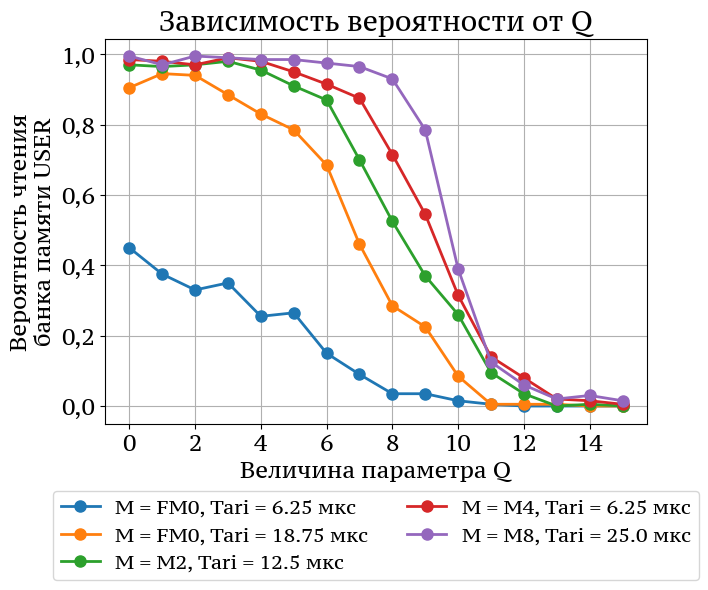

In [6]:
plot_simulations_results(
    results_list=[q_result],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость вероятности от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Q probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае **с коллизиями** и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разного количества меток в зоне действия считывателя.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

In [7]:
def estimate_generation_interval(
    tags_amount: int,
    reading_zone: float,
    speed: float = default_params.speed) -> float:
    """
    Пересчитывает желаемое количество меток в зоне чтения в требуемый интервал генерации.

    На количество меток в зоне чтения влияет размер зоны чтения (зависит от канала),
    скорость движения и период генерации меток.

    Args:
        tags_amount: желаемое количество меток в зоне
        reading_zone: суммарная длина зон, где метка включена (в метрах)
        speed: скорость движения считывателя в км/ч

    Returns:
        Интервал генерации в секундах (временной промежуток между метками)
    """
    # Преобразуем скорость в м/с
    speed_mps = speed * KMPH_TO_MPS_MUL

    return reading_zone / (tags_amount * speed_mps)

In [8]:
# Вычисление длины зоны активности меток
ox_axis = np.linspace(
    - inner_params.geometry_params.initial_distance_to_reader,
    inner_params.geometry_params.initial_distance_to_reader,
    inner_params.geometry_params.grid_step
)
tag_accepted_power = [get_tag_rx(x, speed=0, t=0, power=default_params.power_dbm) for x in ox_axis]
tag_on_intervals = find_zones(ox_axis, tag_accepted_power, use_upper=True)
reading_zone = sum(end - start for start, end in tag_on_intervals)

### ⚙️ Параметры для разных кривых

In [9]:
TAGS_IN_READING_ZONE = (25, 100)

tag_intervals = [
    estimate_generation_interval(n, reading_zone)
    for n in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} меток", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

In [10]:
q_variable = np.arange(0, 16, 1)
colllision_params_list = []

for tag_params_item in tag_period_params:
    colllision_params_list.append({
        'tari': default_params.tari,
        'encoding':  default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        'num_tags': 50,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': False,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"]
    })

### 💾 Получение результатов

In [11]:
key_name = lambda params: f"{params["label"]}"

In [12]:
collision_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision.json"
)
# Моделирование на M3 Pro с 'num_tags': 250:
# Моделирование по переменной q: 100%|██████████| 3/3 [01:09<00:00, 23.16s/it]

### 🖼️ Построение графика

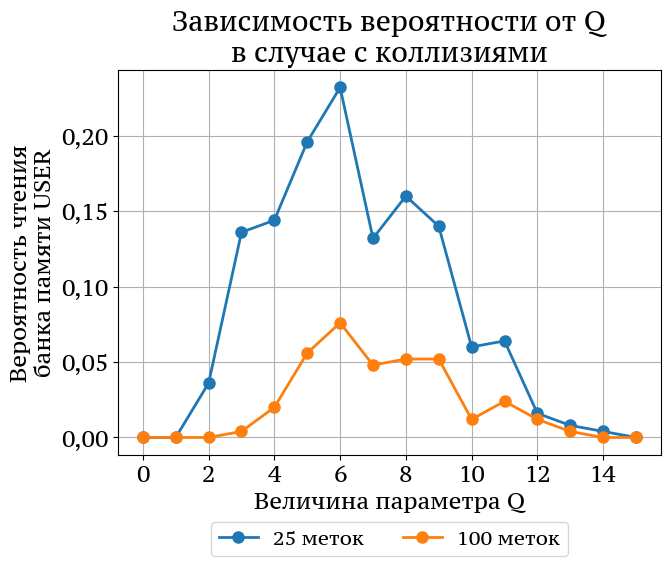

In [13]:
plot_simulations_results(
    results_list=[collision_result],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Collision probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от стартового значения параметра `Q` в случае **с коллизиями с использованием алгоритма QueryAdjust**
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разного количества меток в зоне действия считывателя.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

### ⚙️ Параметры для разных кривых

In [14]:
for tag_params_item in colllision_params_list:
    tag_params_item["useadjust"] = True

### 💾 Получение результатов

In [15]:
key_name = lambda params: f"{params["label"]}"

In [16]:
collision_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=False,
    save_results=True,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision_adjust.json"
)

Моделирование по переменной q: 100%|██████████| 2/2 [00:15<00:00,  7.87s/it]


### 🖼️ Построение графика

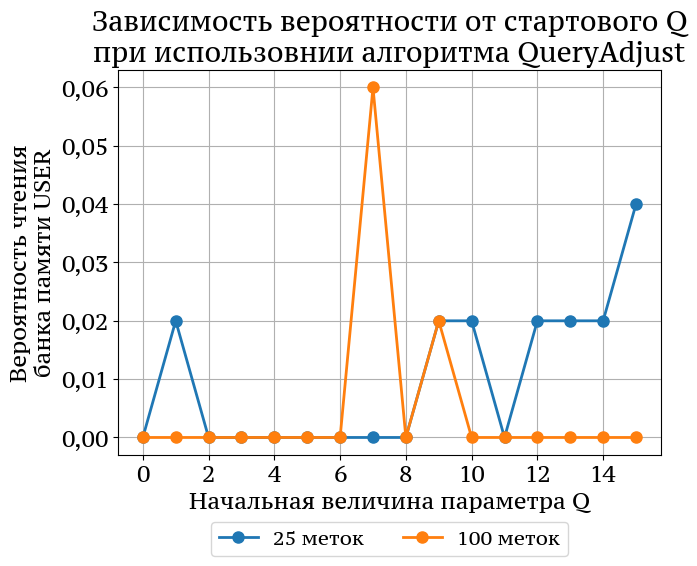

In [17]:
plot_simulations_results(
    results_list=[collision_result],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от стартового Q\nпри использовнии алгоритма QueryAdjust"],
    x_variable=q_variable,
    x_label="Начальная величина параметра Q",
    image_name="Collision probs QAdjust_0",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)